In [36]:
import pandas as pd
import warnings
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
import keras
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error as MSE
from datetime import timedelta

import statsmodels.formula.api as smf

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [38]:
data = pd.read_csv('./data/data_all_before_feeding.csv', names=['Date', 'Number_of'], header=0)

print(data.info())

data.describe()

,Date,Number_of
0,2016-06-27/2016-07-03,5
1,2016-07-04/2016-07-10,8
2,2016-07-11/2016-07-17,2
3,2016-07-18/2016-07-24,2
4,2016-07-25/2016-07-31,3


In [40]:
data['Date'] = data['Date'].str.slice(0, 10)
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d").dt.date
data = data.set_index('Date')[['Number_of']].sort_index().asfreq('W-Mon')

In [41]:
# data.loc[data['Number_of'] >58, 'Number_of'] = 58
data.head()

,Number_of
Date,
2016-06-27,5
2016-07-04,8
2016-07-11,2
2016-07-18,2
2016-07-25,3


<AxesSubplot:xlabel='Date'>

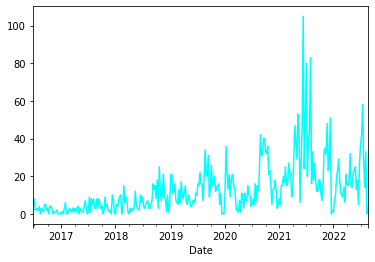

In [42]:
data['Number_of'].plot(c='cyan')

In [43]:
# Using Dickey-Fuller test to determine if time series is stationary

def dickey_fuller_test(timeseries):    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=7*8, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [44]:
# Test original data
dickey_fuller_test(data['Number_of'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.930123
p-value                          0.041956
#Lags Used                       6.000000
Number of Observations Used    315.000000
Critical Value (1%)             -3.451281
Critical Value (5%)             -2.870760
Critical Value (10%)            -2.571682
dtype: float64


In [45]:
# Accourding to data plot and also test results, our data is not stationary, 
# so for more accurate prediction I try to make the time series stationary by differencing method.
# this way I get rid of the varying mean in time series.

<AxesSubplot:xlabel='Date'>

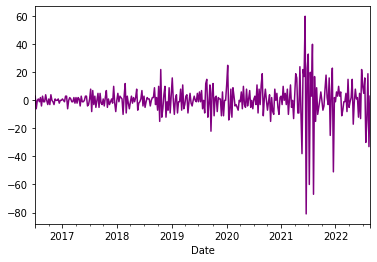

In [46]:
data_delta = data.copy()
data_delta['delta_1'] = data['Number_of'].shift(1)
data_delta.replace([np.inf, -np.inf], np.nan, inplace=True)
data_delta.dropna(inplace=True)
data_delta['Number_of'] = data['Number_of'] - data_delta['delta_1']
data_delta.drop('delta_1', axis=1, inplace=True)
data_delta['Number_of'].plot(c='purple')

In [47]:
# Test original data
dickey_fuller_test(data_delta['Number_of'])

Results of Dickey-Fuller Test:
Test Statistic                -1.117893e+01
p-value                        2.529412e-20
#Lags Used                     5.000000e+00
Number of Observations Used    3.150000e+02
Critical Value (1%)           -3.451281e+00
Critical Value (5%)           -2.870760e+00
Critical Value (10%)          -2.571682e+00
dtype: float64


In [48]:
# As plot and test results show differencing method makes the time series stationary

In [49]:
# I try to create more data and make dataset supervised 
# By adding time lags I define how many past weeks data must used to predict next week sales

historical_data_count_for_prediction = 12
str_name = ''
for i in range(1, historical_data_count_for_prediction+1):
    field_name = 'd_' + str(i)
    str_name += field_name + '+'
    
    data_delta[field_name] = data_delta['Number_of'].shift(i)

data_delta = data_delta.dropna()
data_delta.head()

,Number_of,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12
Date,,,,,,,,,,,,,
2016-09-26,-3.0,0.0,4.0,-1.0,-1.0,3.0,-4.0,2.0,-1.0,1.0,0.0,-6.0,3.0
2016-10-03,1.0,-3.0,0.0,4.0,-1.0,-1.0,3.0,-4.0,2.0,-1.0,1.0,0.0,-6.0
2016-10-10,-3.0,1.0,-3.0,0.0,4.0,-1.0,-1.0,3.0,-4.0,2.0,-1.0,1.0,0.0
2016-10-17,4.0,-3.0,1.0,-3.0,0.0,4.0,-1.0,-1.0,3.0,-4.0,2.0,-1.0,1.0
2016-10-24,0.0,4.0,-3.0,1.0,-3.0,0.0,4.0,-1.0,-1.0,3.0,-4.0,2.0,-1.0


In [50]:
# Define the regression formula, I use it to have some sense how new data feature
model = smf.ols(formula='Number_of ~ ' + str_name[:-1], data=data_delta)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.31725887533350916


In [51]:
# Splitting data to train set and test set,
# defining last n weeks sales info as test data

test_data_size = 24 # last six month of data, 24 weeks
val_data_size = 24
train_data, val_data, test_data = data_delta[0:-(val_data_size+test_data_size)].values, data_delta[-(val_data_size+test_data_size):-(test_data_size)].values, data_delta[-(test_data_size):].values

In [52]:
data_delta[-(test_data_size):].index

DatetimeIndex(['2022-03-14', '2022-03-21', '2022-03-28', '2022-04-04',
               '2022-04-11', '2022-04-18', '2022-04-25', '2022-05-02',
               '2022-05-09', '2022-05-16', '2022-05-23', '2022-05-30',
               '2022-06-06', '2022-06-13', '2022-06-20', '2022-06-27',
               '2022-07-04', '2022-07-11', '2022-07-18', '2022-07-25',
               '2022-08-01', '2022-08-08', '2022-08-15', '2022-08-22'],
              dtype='datetime64[ns]', name='Date', freq='W-MON')

In [53]:
# Scaling data using MinMaxScaler to make better prediction

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_data)

train_data = train_data.reshape(train_data.shape[0], train_data.shape[1])
train_data_scaled = scaler.transform(train_data)

val_data = val_data.reshape(val_data.shape[0], val_data.shape[1])
val_data_scaled = scaler.transform(val_data)

test_data = test_data.reshape(test_data.shape[0], test_data.shape[1])
test_data_scaled = scaler.transform(test_data)

In [54]:
# Making supervised data for feeding to LSTM network

X_train, y_train = train_data_scaled[:, 1:], train_data_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

X_val, y_val = val_data_scaled[:, 1:], val_data_scaled[:, 0:1]
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

X_test, y_test = test_data_scaled[:, 1:], test_data_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [55]:
# Building a very simple LSTM network

model = Sequential()
# model.add(Dropout(0.5))
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2])))#, stateful=True))#, return_sequences=True))
model.add(Dropout(0.5))#, input_shape=(60,)))
# model.add(LSTM(4, ))
model.add(Dense(1, activation='relu'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (1, 4)                    272       
                                                                 
 dropout_1 (Dropout)         (1, 4)                    0         
                                                                 
 dense_1 (Dense)             (1, 1)                    5         
                                                                 
Total params: 277
Trainable params: 277
Non-trainable params: 0
_________________________________________________________________


In [56]:
#Training the network
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
factor = 1. / np.cbrt(2)

model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/quant-risk/Saved Models/", verbose=1, monitor='val_loss', save_best_only=True, save_weights_only=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, mode='auto', factor=factor, cooldown=0, min_lr=1e-10, verbose=2)
es = EarlyStopping(monitor='val_loss', patience=10)
callback_list = [reduce_lr, es]#[model_checkpoint, reduce_lr, es]

optimizer = keras.optimizers.Adam(lr = 0.001)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001)
model.compile(loss='mean_squared_error', 
              optimizer=optimizer)

history = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_val, y_val),
                    epochs=300, 
                    batch_size=1, 
                    verbose=1, 
                    callbacks=callback_list,
                    shuffle=False)

Epoch 1/300
261/261 [==============================] - 3s 8ms/step - loss: 0.0333 - val_loss: 0.0482 - lr: 0.0010
Epoch 2/300
261/261 [==============================] - 1s 3ms/step - loss: 0.0298 - val_loss: 0.0471 - lr: 0.0010
Epoch 3/300
261/261 [==============================] - 1s 3ms/step - loss: 0.0310 - val_loss: 0.0463 - lr: 0.0010
Epoch 4/300
261/261 [==============================] - 1s 4ms/step - loss: 0.0292 - val_loss: 0.0457 - lr: 0.0010
Epoch 5/300
261/261 [==============================] - 1s 3ms/step - loss: 0.0285 - val_loss: 0.0455 - lr: 0.0010
Epoch 6/300
261/261 [==============================] - 1s 3ms/step - loss: 0.0274 - val_loss: 0.0454 - lr: 0.0010
Epoch 7/300
261/261 [==============================] - 1s 3ms/step - loss: 0.0270 - val_loss: 0.0452 - lr: 0.0010
Epoch 8/300
261/261 [==============================] - 1s 3ms/step - loss: 0.0268 - val_loss: 0.0451 - lr: 0.0010
Epoch 9/300
261/261 [==============================] - 1s 3ms/step - loss: 0.0287 - val_

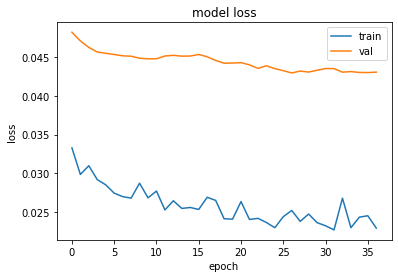

In [57]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [58]:
# Making prediction using the trained model and scale data back

y_pred = model.predict(X_test, batch_size=1)
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

pred_test_data = []
for index in range(0,len(y_pred)):
    pred_test_data.append(np.concatenate([y_pred[index], X_test[index]], axis=1))
    
pred_test_data = np.array(pred_test_data)
pred_test_data = pred_test_data.reshape(pred_test_data.shape[0], pred_test_data.shape[2])

pred_test_data_inverted = scaler.inverse_transform(pred_test_data)

24/24 [==============================] - 0s 2ms/step


In [59]:
# Create dataframe that shows the predicted sales
result_list = []
sales_dates = list(data[-(test_data_size+2):].index)
actual_sales = list(data[-(test_data_size+2):].Number_of)

for index in range(0,len(pred_test_data_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_data_inverted[index][0] + actual_sales[index])
    result_dict['Date'] = sales_dates[index+1]
    result_list.append(result_dict)
    
df_result = pd.DataFrame(result_list)


Root mean squared error: 16.82


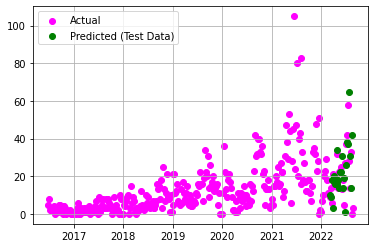

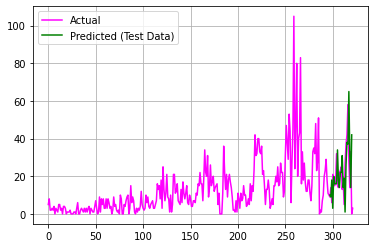

In [60]:
#merge with actual sales dataframe
#plot actual and predicted

data_pred = pd.merge(data, df_result, on='Date', how='left')

test = data_pred[data_pred['pred_value'].isna()==False]
err = 'Root mean squared error: %.2f'% sqrt(MSE(test[['Date','Number_of']]['Number_of'], test[['Date','pred_value']]['pred_value']))

print(err)

fig, ax = plt.subplots()
ax.scatter(
    x=data_pred['Date'],
    y=data_pred['Number_of'],
    c='magenta'
)
ax.scatter(
    x=data_pred['Date'],
    y=data_pred['pred_value'],
    c='g'
    )
    
ax.legend(['Actual', 'Predicted (Test Data)'])
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(data_pred['Number_of'], c='magenta')
ax.plot(data_pred['pred_value'], c='g')
ax.legend(['Actual', 'Predicted (Test Data)'])
ax.grid(True)

In [61]:
week_index = pd.to_datetime('2022-08-28').date().strftime(format='%Y-%m-%d')
week_list = [week_index]

month_count_to_multistep_prediction = 1
for i in range(month_count_to_multistep_prediction * 4):
    week_index = pd.to_datetime(week_index) + timedelta(days=7)
    week_index = week_index.date().strftime(format='%Y-%m-%d')
    week_list.append(week_index)

temp = pd.DataFrame({'Date': week_list, 'Number_of': [None] * ((month_count_to_multistep_prediction * 4)+1)})
temp = temp.set_index('Date')[['Number_of']].sort_index().asfreq('W-Mon')

weekly_sales_prediction = data_delta[['Number_of']].tail(historical_data_count_for_prediction).copy()
weekly_sales_prediction = weekly_sales_prediction.append(temp)

str_name = ''
for i in range(1, historical_data_count_for_prediction+1):
    field_name = 'd_' + str(i)
    str_name += field_name + '+'
    
    weekly_sales_prediction[field_name] = weekly_sales_prediction['Number_of'].shift(i)

weekly_sales_prediction = weekly_sales_prediction['2022-08-29':]
week_list = weekly_sales_prediction.index.to_list()

for i in range(len(weekly_sales_prediction)):
    temp = weekly_sales_prediction.loc[week_list[i]].values.reshape(1,-1)
    temp_scaled = scaler.transform(temp)
    temp_scaled = np.squeeze(temp_scaled)[1:].reshape(1, 1, historical_data_count_for_prediction)

    next_pred = model.predict(temp_scaled, batch_size=1)
    temp = temp_scaled.reshape(1, historical_data_count_for_prediction)
    temp = np.insert(temp, 0, next_pred).reshape(1, historical_data_count_for_prediction+1)
    next_pred_inverted = scaler.inverse_transform(temp)
    weekly_sales_prediction.loc[week_list[i]]['Number_of'] = next_pred_inverted[0][0]
    
    c = 1
    for j in range(i+1, len(weekly_sales_prediction)):
        if j < len(weekly_sales_prediction):            
            weekly_sales_prediction.loc[week_list[j]]['d_' + str(c)] = next_pred_inverted[0][0]
            c += 1            

1/1 [==============================] - 0s 21ms/step


In [62]:
final_weekly_prediction = weekly_sales_prediction.copy()
final_weekly_prediction['delta_1'] = weekly_sales_prediction['Number_of'].shift(1)
final_weekly_prediction['delta_1'].loc['2022-08-29'] = data[['Number_of']].tail(1)['Number_of'].values

final_weekly_prediction['Number_of_predicted'] = final_weekly_prediction['Number_of'] + final_weekly_prediction['delta_1']
final_weekly_prediction.drop('Number_of', axis=1, inplace=True)

final_weekly_prediction.reset_index(inplace=True)
data_pred = pd.concat([data_pred, final_weekly_prediction[['Date', 'Number_of_predicted']]])

data_pred = data_pred.set_index('Date').sort_index().asfreq('W-Mon')
data_pred.reset_index(inplace=True)

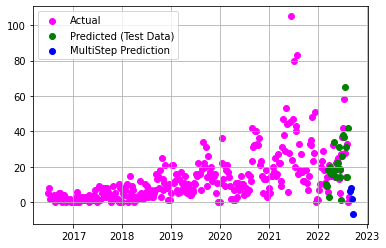

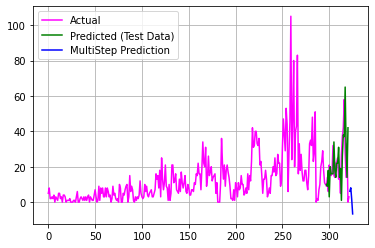

In [63]:
fig, ax = plt.subplots()
ax.scatter(
    x=data_pred['Date'],
    y=data_pred['Number_of'],
    c='magenta'
)
ax.scatter(
    x=data_pred['Date'],
    y=data_pred['pred_value'],
    c='g'
    )
ax.scatter(
    x=data_pred['Date'],
    y=data_pred['Number_of_predicted'],
    c='b'
    )
    
ax.legend(['Actual', 'Predicted (Test Data)', 'MultiStep Prediction'])
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(data_pred['Number_of'], c='magenta')
ax.plot(data_pred['pred_value'], c='g')
ax.plot(data_pred['Number_of_predicted'], c='b')
ax.legend(['Actual', 'Predicted (Test Data)', 'MultiStep Prediction'])
ax.grid(True)

In [64]:
print('Multi step sales prediction results:')
results = data_pred.copy()
results = results.tail(month_count_to_multistep_prediction * 4)
results['Number_of_predicted'] = results['Number_of_predicted'].astype(int)
results[['Date', 'Number_of_predicted']]

Multi step sales prediction results:


,Date,Number_of_predicted
322,2022-08-29,6
323,2022-09-05,8
324,2022-09-12,1
325,2022-09-19,-6
